In [ ]:
# mount drive
from google.colab import drive
drive.mount("/drive") 

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# imports
import numpy as np
import pandas as pd

In [ ]:
# imports for plots
from plotly import graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "plotly_white"

In [ ]:
# load data
# weather variables to use
selected_cols = ["cumulative_GDD", "cumulative_PREC", "cumulative_WS2M"]

dict_data = {}

for col in selected_cols:
  pathname = f"/drive/My Drive/Colab Notebooks/AgriEdge/data_univariate_clustering/{col}.csv"

  dict_data[col] = pd.read_csv(pathname, index_col=0)

In [ ]:
# scale data
# min-max noramalization
dict_scaled_data = {}

for col in selected_cols:
  data = dict_data[col]

  max_val = np.max(data.values)
  min_val = np.min(data.values)

  dict_scaled_data[col] = (data - min_val) / (max_val - min_val)


In [ ]:
fig = go.Figure(data=[
                      go.Scatter(y=y, marker_color="blue")
                      for y in dict_scaled_data["cumulative_PREC"].values
])

fig.show()

In [ ]:
# standarize
# only substruct mean 
dict_standarized_data = {}

for col in selected_cols:
  # select data
  data = dict_scaled_data[col].copy()

  # standarize each var
  for var in dict_data[col]:
    data[var] = (data[var] - data[var].mean()) # / data[var].std()

  dict_standarized_data[col] = data

In [ ]:
# merge data
merged_data = dict_standarized_data[selected_cols[0]]

for i in range(1, len(selected_cols)):
  col = selected_cols[i]
  merged_data = merged_data.join(dict_standarized_data[col], rsuffix='_other')

In [ ]:
merged_data["268"].max()
merged_data["268_other"].max()

268_other    0.458056
268_other    0.099334
dtype: float64

In [ ]:
# explanatory PCA
from sklearn.decomposition import PCA

# build
pca = PCA()

# fit
pca.fit(merged_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# explained varaiance ration chart
# bar chart

component_names = [f"component_{i}" for i in range(1, len(pca.explained_variance_ratio_) + 1)]

fig = go.Figure(data=[
                      go.Bar(y=["Explained variance ratio"], x=[pca.explained_variance_ratio_[i]], name=component_names[i], orientation='h')
                      for i in range(len(pca.explained_variance_ratio_))
])


fig.update_layout(
    title_text="Explained variance ratio for each PC",
    height=500,
    width=1000,
    barmode="stack",
    xaxis={
    "tickformat": ',.0%',
    "range": [0,1]
  }
)

fig.show()

In [ ]:
# more insightful graph to select number of PC
# cumulative explained variance ratio

cumulative_explained_var = pd.Series(pca.explained_variance_ratio_).cumsum()

fig = go.Figure(data=[
                      go.Scatter(y=cumulative_explained_var, mode="markers+lines")
])

fig.update_layout(
    title_text="Cumulative explained variance",
    height=500,
    width=1000,
    xaxis={
        "title": "PC",
        "range": [-0.5, 20]
        },
    yaxis={
        "title": "explained variance",
        "tickformat": ',.0%',
        "range": [0.4, 1.05]
        }
)

fig.show()

In [ ]:
# use of the above graph to select suitable
# number of PC to keep

from sklearn.decomposition import PCA

# build
nb_components = 10
pca = PCA(n_components=nb_components)

# fit
pca.fit(merged_data)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# Transform data to the PCA space
# where the dimension is reduced
# to perform clustering

transformed_data = pca.transform(merged_data)

transformed_data

array([[ 7.44974134e-01,  1.22948452e+00,  1.65756394e-01,
        -6.39569017e-01,  8.98710454e-02, -7.07885137e-02,
        -2.07177993e-01, -3.61164973e-01,  6.75869421e-02,
         1.58971462e-02],
       [-9.31189134e-01, -2.71550035e-01,  1.46322436e-01,
         2.87025079e-01,  2.02402246e-01, -2.31137269e-01,
        -7.44148318e-02,  5.22722310e-02,  2.63819462e-01,
         4.23082449e-02],
       [-9.17851972e-01,  1.06293499e-01,  6.87820595e-02,
        -1.48599459e-01, -4.67933180e-01, -1.85647187e-01,
        -6.16282507e-02, -1.20538014e-01, -1.67744661e-01,
         1.68810460e-01],
       [-2.05282546e+00, -8.41905048e-02, -7.98124910e-01,
         6.11357809e-01, -7.22128765e-01, -7.04448657e-03,
        -2.03685264e-01,  5.12533452e-02, -3.22247775e-02,
         4.08545948e-02],
       [-6.84429982e-01,  5.84471052e-01, -2.85503266e-01,
         6.39675402e-01, -6.53486152e-02, -8.27703203e-02,
        -1.30106503e-01,  6.89090435e-02, -5.06383797e-02,
        -5.

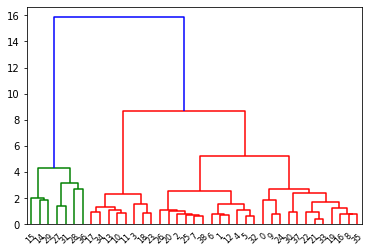

In [ ]:
# clustering 

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# params
metric = "euclidean"
linkage_method = "ward"

Z = linkage(transformed_data, metric=metric, method=linkage_method)
# fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [ ]:
# selected suitable number of clusters
# then score this clustering approach

# use Calanski-Harabasz index
# to choose the right number of cluster

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics


# where to store CH index
arr_calanski = {}

# max possible number of cluster
max_k = 10

# data
X = transformed_data

# loop over number of clusters
for k in range(2, max_k):
  # build model 
  model = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, affinity=metric)
  model = model.fit(X)

  # clusters label
  labels = model.fit_predict(X)

  # compute calanski metric
  m = metrics.calinski_harabasz_score(X, labels)

  arr_calanski[k] = m


# plot of CH index
fig = go.Figure(data=[
                      go.Scatter(x=list(arr_calanski.keys()), y=list(arr_calanski.values()))
])

fig.update_layout(
    width=800,
    height=500,
    xaxis_title="number of cluster",
    yaxis_title="Calanski-Harbasz index"
)

fig.show()

In [ ]:
# generate labels
from sklearn.decomposition import PCA

# build
nb_components = 10
pca = PCA(n_components=nb_components)
# fit then transform
pca.fit(merged_data)
transformed_data = pca.transform(merged_data)

# build model
nb_clusters = 3
model = AgglomerativeClustering(n_clusters=nb_clusters, linkage=linkage_method, affinity=metric)
model = model.fit(transformed_data)
# clusters label
labels = model.fit_predict(transformed_data)

labels

array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 1, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 1, 0, 0])

In [ ]:
# make a 2D visualisation of the cluster

# reduce data
from sklearn.decomposition import PCA

# build
nb_components = 2
pca = PCA(n_components=nb_components)
# fit then transform
pca.fit(merged_data)
transformed_data = pca.transform(merged_data)


# cluster data
from sklearn.cluster import AgglomerativeClustering

# build model
nb_clusters = 3
model = AgglomerativeClustering(n_clusters=nb_clusters, linkage=linkage_method, affinity=metric)
model = model.fit(transformed_data)
# clusters label
labels = model.fit_predict(transformed_data)

df = pd.DataFrame(transformed_data, columns=["x", "y"])
df["cluster"] = labels.astype(str)
df["crop_year"] = dict_data["cumulative_GDD"].index

# make plot
fig = px.scatter(df, x="x", y="y", color="cluster", text="crop_year")

fig.update_traces(textposition='top center')

fig.show()

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 1982 to 2020
Columns: 807 entries, 0 to 268_other
dtypes: float64(807)
memory usage: 247.4 KB
